# Process Overview for Traffic Detection in Images

In this notebook will be using computer vision in order to detect and count vehicles in the traffic images.

The process of the vehicle detection and counting can be graphically summarized as follows:
![img](../images/notebook_images/image_detection_process.jpg)

1. First the input image is loaded from the image database
2. Next the image is masked in order to only keep the region of interest (ROI) for the image detection model to work on
3. Use YOLOv7 with OpenCV2 to detect all the instance of vehicles in the masked image
4. Add back the masked out parts of the image for storing and display to end users

## Performance and accuracy of image detection

#### Performance
The image detection process was conducted on a **AMD Ryzen 5900X laptop CPU** (detection with GPU currently not supported with the pip version of Python OpenCV2). Using the CPU, we were able to achieve a pre-processing and detection speed of about **1.0 to 1.4 frames second**

#### Accuracy
Using the pretrained YOLOv7 DNN model, we were able to detect majority of the vehicles in the region of interest, in both daytime and night conditions:

![img](../images/notebook_images/image_detection/detection_accuracy/detection_accuracy_combined.jpg)

However, for a more quantitative measure of detection accuracy, we would need to manually label the traffic images and compare the number of vehicles detected against the ground truth. Due to time constraint manual labelling of images is outside the scope of this project.

## Known issues and potential improvements

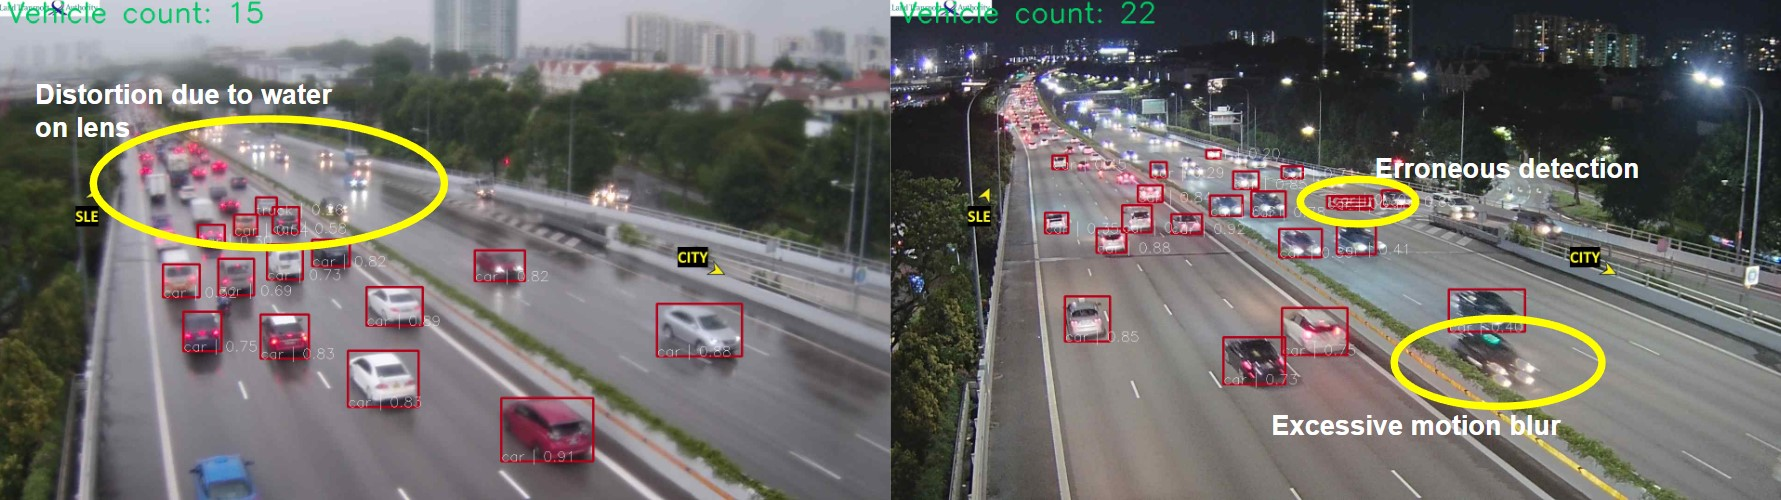Despite having reasonable accuracy in detecting vehicles there are several instances of detection error, such as those shown below:

![img](../images/notebook_images/image_detection/detection_issues/detection_issues_combined.jpg)

These issues can potentially be solved by the following:
- Custom training the YOLOv7 model to detect:
    - Smaller instances of vehicles (the original COCO dataset may not contain vehicles from far away)
    - Vehicles during night-time (especially vehicles which are occluded by its own headlights/taillights)
- Fine tuning of YOLOv7 detection confidence threshold
- Improvement on traffic cameras for detection during the rain, such as:
    - Proper rain cover for traffic cameras, or
    - Use of hydrophobic lens coating which eliminates or reduces water droplets on the camera lens
    - Use of higher sensitivity / ISO cameras for nighttime detection in order to reduce shutter speed and motion blur

# Imports

In [20]:
import cv2
import numpy as np
import glob

from datetime import datetime as dt

import os
import shutil

import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm

# Vehicle Detector Class & Function

In [21]:
class VehicleDetector:
    '''
    This class is used to contain the vehicle detector using the pretrained YOLOv7
    Using self.class_allowed, the user can filter which types of objects (or vehicles) that is detected
    '''

    def __init__(self):
        # initialize the class by loading the pre-trained model and setting the allowable classes
        
        # Load DNN from pre-trained model
        net = cv2.dnn.readNet("../dnn_model/yolov7.weights", "../dnn_model/yolov7.cfg")
        
        # setup model and parameters
        self.model = cv2.dnn_DetectionModel(net)
        self.model.setNmsAcrossClasses(True) # setting so that the NMS applies across different classes
        self.model.setInputParams(size=(832, 832), scale=1 / 255)

        # Allow classes containing Vehicles only
        self.classes_allowed = [1, 2, 3, 5, 7] # classes are same as COCO class, but SUBTRACT BY ONE, 
        # i.e.: {1:'bicycle', 2:'car',3:'motorcycle', 5:'bus', 7:'truck'}


    def detect_vehicles(self, img):
        '''
        This function takes an image and returns the bounding boxes of vehicles detected inside
        '''
        # Create a list to contain all detected instance of vehicles
        vehicle_boxes = []
        
        # detect if a none-type image is loaded (could be because of image error) and returns an error, this will be caught later in the main detection function
        if img is None:
            vehicle_boxes = ['image_error!']
            return vehicle_boxes
        
        # Detect Objects
        class_ids, scores, boxes = self.model.detect(img, 
                                                     nmsThreshold=0.5, # NMS threshold --> higher = more close boxes together
                                                     confThreshold=0.15)
        # looping through each object detected
        for class_id, score, box in zip(class_ids, scores, boxes):
            # if the object is within the allowed class, then add the item in the vehicle_boxes list
            if class_id in self.classes_allowed:
                vehicle_boxes.append({'class_id':class_id+1,
                                      'score':score,
                                      'box':box})

        return vehicle_boxes
    
    
    
    def preprocess(self,src,mask_path=None): 
        '''
        This is a helper function to preprocess the image given a mask
        In this particular instance, no further preprocessing was implemented,
        but in theory, sharpening or contrast correction could be added here to help the image detection algorithm
        '''
    
        img=src

        # load mask from directory
        if mask_path==None: # if no maks is specified, then generate a white mask (i.e.: everything will pass)
            mask = np.zeros((1080,1920),dtype=np.uint8)
            mask[:] = 255

        else: # if a mask is specified, then use the pre-defined mask
            mask = cv2.imread(mask_path)
            mask = cv2.cvtColor(mask,cv2.COLOR_RGB2GRAY)

        # masking image using the pre-defined mask
        img = cv2.bitwise_or(src,src,mask=mask)

        # other image preprocessing here (disabled here as they does not improve detection accuracy)
        # hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert image to hsv
        # hsv[:,:,2] = cv2.equalizeHist(hsv[:,:,2]) # equalize the lightness
        # img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR) # convert image back to RGB

        return img

# Vehicle Counting Function

In [31]:
def vehicle_count(input_folder_directory, output_folder_directory, mask_path=None):
    '''
    This function will conduct image detection on a folder of traffic images, and then save the output to a predefined output folder.
    You may also define a mask file in order to mask at the traffic images. 
    For the masking function to work properly you will need to use one function call per camera id.
    The function will return a pandas dataframe which will contain the vehicle count along with the time stamp
    '''

    # define vehicle dictionary
    object_dictionary = {2:'bicycle',3:'car',4:'motorcycle',6:'bus',8:'truck'}

    # Load Veichle Detector class
    vd = VehicleDetector()

    # Load images paths
    image_paths = glob.glob(pathname=input_folder_directory+"/**/*.jpg", # finding all .jpg file in the input folder
                            recursive=True) 

    # convert the image_paths list into a tqdm for displaying progress bar
    image_paths_pbar = tqdm(image_paths)

    # instantiate df for counting vehicle types
    vehicle_count_df = pd.DataFrame(columns=object_dictionary.keys())

    # Loop through all the images
    for img_path in image_paths_pbar:

        # Showing output
        filename = os.path.basename(img_path)
        image_paths_pbar.set_description(f"Analyzing file: {filename}") # display current file in pbar

        # read the image from path
        img = cv2.imread(img_path)
        
        # catch none-type images here
        if img is None:
            print(f'error in loading image {filename}')
            continue
        
        # create a clean copy to be outputed later
        output_img = img.copy() 

        # preprocess the image
        try:
            img = vd.preprocess(src=img,
                                mask_path=mask_path)
        except:
            img = output_img
            print(f'error in preprocessing {filename}')

            
        # image detection
        vehicle_boxes = vd.detect_vehicles(img)

        # error catching for bad images
        if vehicle_boxes == ['image_error!']:
            print(f'image detection error on {filename}') # display the errored image
            continue
        
        # DETECTING VEHICLES
        # use the vehicle_count function to return the vehicle boxes
        vehicle_count = len(vehicle_boxes)

        ## [FOR DEBUGGING ONLY!] using the original image for the output
        # output_img = img
        
        # DRAWING BOUNDING BOXES
        for vehicle_box in vehicle_boxes:
            x, y, w, h = vehicle_box['box']

            cv2.rectangle(output_img, (x, y), (x + w, y + h), (25, 0, 180), 3)
            cv2.putText(output_img, f"{object_dictionary[vehicle_box['class_id']]} | {vehicle_box['score']:.2f}", (x, y + h), 0, 1, (255, 255, 255), 1)

        # ADDING TEXT WITH VEHICLE COUNT
        cv2.putText(output_img, "Vehicle count: " + str(vehicle_count), (20, 50), 0, 2, (100, 200, 0), 3)

        # SAVING OUTPUT IMAGE
        img_path_out = output_folder_directory + '/' + filename
        
        # create folder if doesn't exist
        if not os.path.exists(output_folder_directory):
            os.makedirs(output_folder_directory)
            
        cv2.imwrite(img_path_out, output_img)
        
        # WRITING THE VEHICLE COUNT DATA TO THE DATAFRAME
        try:
            vehicle_count_df.loc[filename,:] = pd.DataFrame(vehicle_boxes)['class_id'].value_counts()
            vehicle_count_df.loc[filename,:] = vehicle_count_df.loc[filename,:].fillna(0)
        except:
            vehicle_count_df.loc[filename,:] = 0
    
    # PRE-FORMATTING THE OUTPUT DATAFRAME
    vehicle_count_df = vehicle_count_df.astype(int) # converting all counts to integer
    vehicle_count_df = vehicle_count_df.rename(columns=object_dictionary) # rename vehicle count columns to the actual vehicle names
    vehicle_count_df = vehicle_count_df.reset_index().rename(columns={'index': 'filename'}) # reset index and save it as a fiename column
    
    # extracting the camera_id from the filename (i.e.: the first series of digits before the first dash '-')
    vehicle_count_df['camera_id'] = vehicle_count_df['filename'].apply(lambda x: x.split('-')[0]).astype(int)
    
    # extracting the timestamp from the filename (i.e.: the series of digits after the first dash '-')
    vehicle_count_df['timestamp'] = vehicle_count_df['filename'].apply(lambda x: x.split('-')[1]) # extracting the digits representing timestamp
    vehicle_count_df['timestamp'] = vehicle_count_df['timestamp'].apply(lambda x: dt.strptime(x, "%Y_%m_%d_%H_%M")) # converting the digits to datetime item
    
    # extracting the md5 hash from the filename (i.e.: the last series of string after the 2nd dash '-')
    vehicle_count_df['md5'] = vehicle_count_df['filename'].apply(lambda x: x.split('-')[2][:-4])
    
    # getting the total count
    vehicle_count_df['total'] = vehicle_count_df[['bicycle','car','motorcycle','bus','truck']].sum(axis=1)
    
    # rearranging the dataframe columns
    vehicle_count_df = vehicle_count_df[['camera_id', 'timestamp', 'md5', 'bicycle', 'car', 'motorcycle', 'bus', 'truck','total']]

    return vehicle_count_df

# Counting Vehicles

This section shows the two ways in which the vehicle counting function can be used

Detection on single camera in one folder

In [33]:
# calling the image detection function
vehicle_count_df = vehicle_count(input_folder_directory="C:/capstone_traffic_images_test", 
                                 output_folder_directory="C:/capstone_traffic_images_test_output/",
                                 mask_path="C:/capstone_traffic_images/mask_img/1702.jpg",
                                )

# optionally, save the vehicle_count_df using the following:
vehicle_count_df.to_csv('../data/traffic_count/counting_test.csv')

Analyzing file: 1702-2022_10_01_12_32-a21a397031f7bec94113d11e56354e3d.jpg: 100%|████████| 2/2 [00:01<00:00,  1.14it/s]


Detection on multiple cameras in multiple folders (note that the images from each camera should be stored in its individual folders with the camera id as the foldername)

In [34]:
# alternatively, we can use f-string literals in order to do batch detection on multiple camera folders:

camera_id_list = [1702,2705,2706,3702,3793,3797,4702,4706,4708,4799,5795,6704,6708,6710,6714,6715,7793,7794,7797,8701,8704,9706]

for camera_id in camera_id_list:
    vehicle_count_df = vehicle_count(input_folder_directory=f"C:/capstone_traffic_images/{camera_id}/", 
                                     output_folder_directory=f"C:/capstone_traffic_images_output/",
                                     mask_path=f"C:/capstone_traffic_images/mask_img/{camera_id}.jpg",
                                    )
    
    # optionally, save the vehicle_count_df using the following:
    vehicle_count_df.to_csv(f'../data/traffic_count/test/{camera_id}.csv')